# ---------------Organizational Network Analysis-----------------

# Preface

Mayur Inc. (fictional name) is a an automobile manufacturers headquartered in US. The company is also expanded in UK, France, Germany, and Brazil. Recently, due to COVID outbreak, many employees are required to work from home. Amid recent challenging time, the fear of loss in productivity and organisational knowledge is more apparent than ever. In order to avoid knowledge loss and loss in productivity due to virtual communication, top management along with Technical Communication department are keen to understand the current communication network and want to know who are the influencers in the organisation. The insights and recommendations will be used to improve the networking in the organisation. The project uses the Python programming language to perform exploratory data analysis and hypothesis testing to extract valuable insights and results using the network analysis.

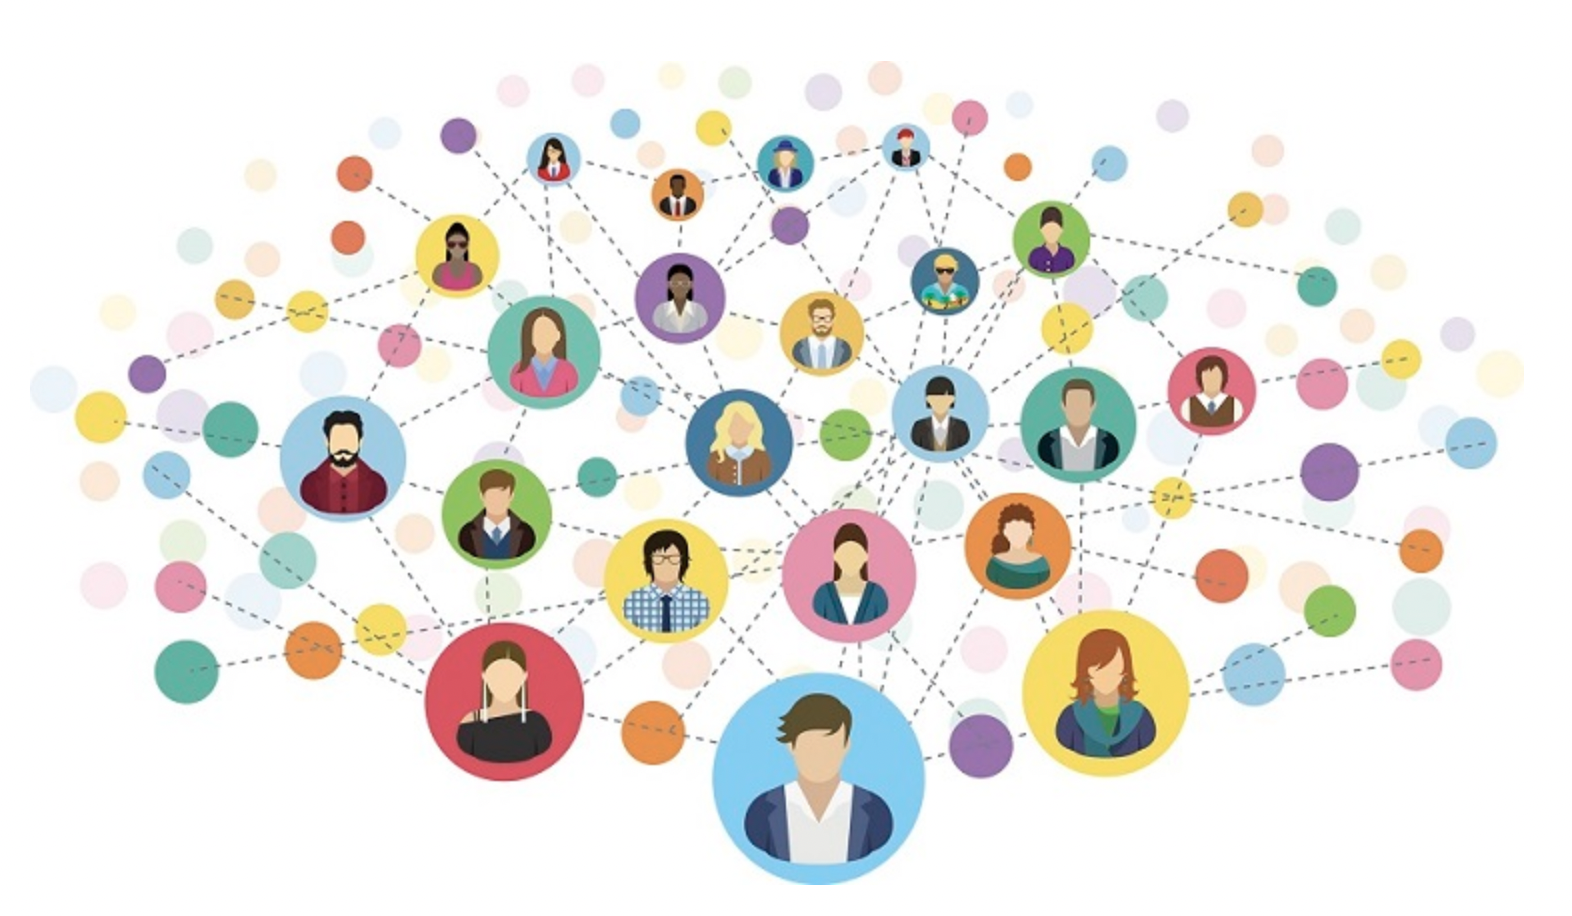

## The dataset

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available

#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.


# Scope

The project covers the following:  
  1. Which departments are the most/least active?
  2. Which employee has the most connections? 
  3. Identify the most influential departments and employees.
  4. In which departments would you recommend the HR team focus to boost collaboration?

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Reading CSV files

In [2]:
messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])
messages.head()

sender  receiver           timestamp  message_length
0      79        48 2021-06-02 05:41:34              88
1      79        63 2021-06-02 05:42:15              72
2      79        58 2021-06-02 05:44:24              86
3      79        70 2021-06-02 05:49:07              26
4      79       109 2021-06-02 19:51:47              73

In [3]:
employees = pd.read_csv('data/employees.csv')
employees.head()

id  department location  age
0   3  Operations       US   33
1   6       Sales       UK   50
2   8          IT   Brasil   54
3   9       Admin       UK   32
4  12  Operations   Brasil   51

# Undestanding the Data

In [4]:
messages.shape

(3512, 4)

In [5]:
employees.shape

(664, 4)

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sender          3512 non-null   int64         
 1   receiver        3512 non-null   int64         
 2   timestamp       3512 non-null   datetime64[ns]
 3   message_length  3512 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 109.9 KB


In [7]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          664 non-null    int64 
 1   department  664 non-null    object
 2   location    664 non-null    object
 3   age         664 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.9+ KB


In [8]:
messages.isna().sum()

sender            0
receiver          0
timestamp         0
message_length    0
dtype: int64

In [9]:
employees.isna().sum()

id            0
department    0
location      0
age           0
dtype: int64

### Observations:
-  Good thing is that there are no NaN in the dataset i.e. no missing values in both the datasets
-  Datatypes of the columns also appear to be inline with what the values in the column represent

Let's have a look at statistics of the datasets. First we will check for numerical values and then for categorical values. Checking statistics for all columns in the datasets does not make much sense. Thus, we will filter the rows which helps us in further analysis. Analysing cental tendencies and dispersions for employee ID columns would mean nothing for us.

In [10]:
messages["message_length"].describe()

count    3512.000000
mean       48.450740
std        22.857461
min        10.000000
25%        29.000000
50%        49.000000
75%        68.000000
max        88.000000
Name: message_length, dtype: float64

In [11]:
employees["age"].describe()

count    664.000000
mean      40.921687
std       10.489521
min       22.000000
25%       33.000000
50%       40.000000
75%       50.000000
max       59.000000
Name: age, dtype: float64

In [12]:
# statistics for categorical columns
# 'messages' dataframe has no categorical columns
employees.describe(include = "O")

department location
count         664      664
unique          6        5
top         Sales       US
freq          161      277

### Observations: 

#### messages-message_length
- Average message lenght was 48 words
- Shortest message sent was of 10 words whereas longest message had 88 words

#### employees-age
- Average age of the employee is almost 40 years
- Dataset covers the youngest employee with age 22 years and oldest employee with age 59 years

#### employees-department & location
- Data is collected from 6 different department and 5 different countries
- Maximum number of employees are from sales department and and from USA.

# Feature Engineering

Having scope in front of the eyes, we will merge both the datasets to find the answers to our questions. In other words, the resulting dataset will include sender's and reciever's additional information. We have to just make sure about adding right suffixes in the new dataframe

In [13]:
# merging dataframes for sender
comm = messages.merge(employees, how="left", left_on="sender", right_on="id")
# merging dataframes for receiver
comm = comm.merge(employees, how="left", left_on="receiver", right_on="id", suffixes=("_sender", "_receiver"))
comm.head()

sender  receiver           timestamp  message_length  id_sender  \
0      79        48 2021-06-02 05:41:34              88         79   
1      79        63 2021-06-02 05:42:15              72         79   
2      79        58 2021-06-02 05:44:24              86         79   
3      79        70 2021-06-02 05:49:07              26         79   
4      79       109 2021-06-02 19:51:47              73         79   

  department_sender location_sender  age_sender  id_receiver  \
0             Sales          France          33           48   
1             Sales          France          33           63   
2             Sales          France          33           58   
3             Sales          France          33           70   
4             Sales          France          33          109   

  department_receiver location_receiver  age_receiver  
0                  IT            France            34  
1               Sales            France            38  
2               Sales           Germany            40  
3          Operations            France            47  
4           Marketing            Brasil            32

In [14]:
comm.columns

Index(['sender', 'receiver', 'timestamp', 'message_length', 'id_sender',
       'department_sender', 'location_sender', 'age_sender', 'id_receiver',
       'department_receiver', 'location_receiver', 'age_receiver'],
      dtype='object')

Before we move further with our analysis, we will do few modifications to the dataframe as some columns are redundant which got added while merging operation

In [15]:
# removing id_sender and id_receiver columns
comm = comm[['sender', 'receiver', 'timestamp', 'message_length', 
       'department_sender', 'location_sender', 'age_sender',
       'department_receiver', 'location_receiver', 'age_receiver']]

For simplicity and flexibility, we can also split time stamp into weekday, month, and time

In [16]:
comm["weekday"]= comm["timestamp"].dt.weekday
comm["month"] = comm["timestamp"].dt.month

In [17]:
comm.head()

sender  receiver           timestamp  message_length department_sender  \
0      79        48 2021-06-02 05:41:34              88             Sales   
1      79        63 2021-06-02 05:42:15              72             Sales   
2      79        58 2021-06-02 05:44:24              86             Sales   
3      79        70 2021-06-02 05:49:07              26             Sales   
4      79       109 2021-06-02 19:51:47              73             Sales   

  location_sender  age_sender department_receiver location_receiver  \
0          France          33                  IT            France   
1          France          33               Sales            France   
2          France          33               Sales           Germany   
3          France          33          Operations            France   
4          France          33           Marketing            Brasil   

   age_receiver  weekday  month  
0            34        2      6  
1            38        2      6  
2            40        2      6  
3            47        2      6  
4            32        2      6

##### Now we have our dataset ready for exploratory data analysis. So, what are we waiting for?? let's jump to it 

# Exploratory Data Analysis

## Distribution for age of senders and receivers

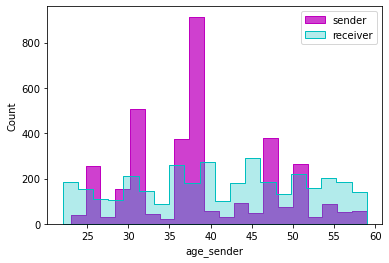

In [18]:
sns.histplot(x="age_sender", bins=20, data= comm, element="step", color="m", label="sender")
sns.histplot(x="age_receiver", bins=20,data=comm, element= "step", color="c", alpha=0.3, label="receiver")
plt.legend()
plt.show()


People who sent more messages are clustered around certain age groups. Maximum messages are sent by employees who are bewteen 35 to 40 years old. While number of senders are more than receivers around the cluster area, distribution for receivers shows somewhat uniform nature.

## Distribution for message length

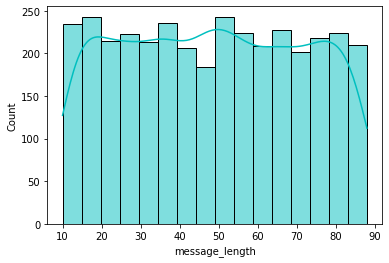

In [19]:
sns.histplot(x="message_length", data=comm, color= "c", alpha=0.5, kde=True)
plt.show()

Longest message sent was of 88 words and the shortest was of 10 words. The message length can be approximated to the uniform distribution. 

## Employee proportion 

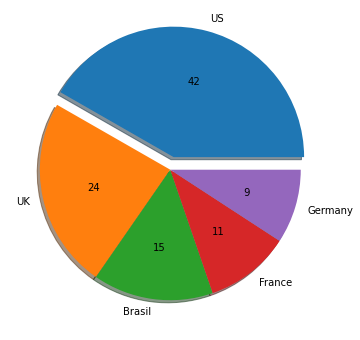

In [20]:
prop=employees.location.value_counts()
plt.figure(figsize=(6,6))
plt.pie(prop, autopct='%2.f', labels=employees.location.unique(), shadow=True, explode=[0.1,0,0,0,0]);

Almost 42% employees included in the dataset are working in US which is near to double as that of UK. Employees working in Germany constitutes the least proportion in the dataset

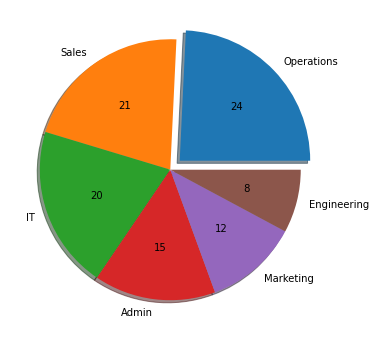

In [21]:
dpt = employees.department.value_counts()
plt.figure(figsize=(6,6))
plt.pie(dpt, autopct='%2.f', labels=employees.department.unique(), shadow=True, explode=[0.1,0,0,0,0,0]);

Data contained the most (24%) employees from Operations department whereas the least(8%) employees from the Engineering department

## Messages sent/ received as per Locations

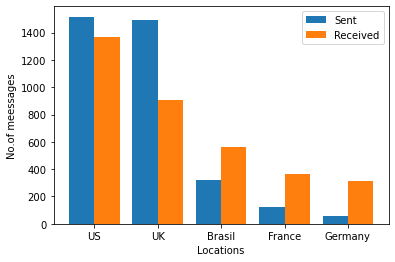

In [22]:
# Finding length of lables for x-axis
loc = list(employees.location.unique())
x_axis= np.arange(len(loc))

loc_send_count= comm.location_sender.value_counts()
loc_receive_count=comm.location_receiver.value_counts()

plt.figure(figsize=(6,4))
plt.bar(x_axis -0.2, loc_send_count, width=0.4, label = 'Sent')
plt.bar(x_axis +0.2, loc_receive_count, width=0.4, label = 'Received')
plt.xticks(x_axis, loc)
plt.xlabel('Locations')
plt.ylabel('No.of meessages')
plt.legend()
plt.show()

## The most and least active departments

In [23]:
# month-wise grouping-------------------------------------------------
month_send = comm.groupby(["month","department_sender"])["sender"].count().reset_index()
month_receive = comm.groupby(["month","department_receiver"])["receiver"].count().reset_index()
# weekday-wise grouping-----------------------------------------------
weekday_sender = comm.groupby(["weekday", "department_sender"])["sender"].count().reset_index()
weekday_receiver = comm.groupby(["weekday", "department_receiver"])["receiver"].count().reset_index()

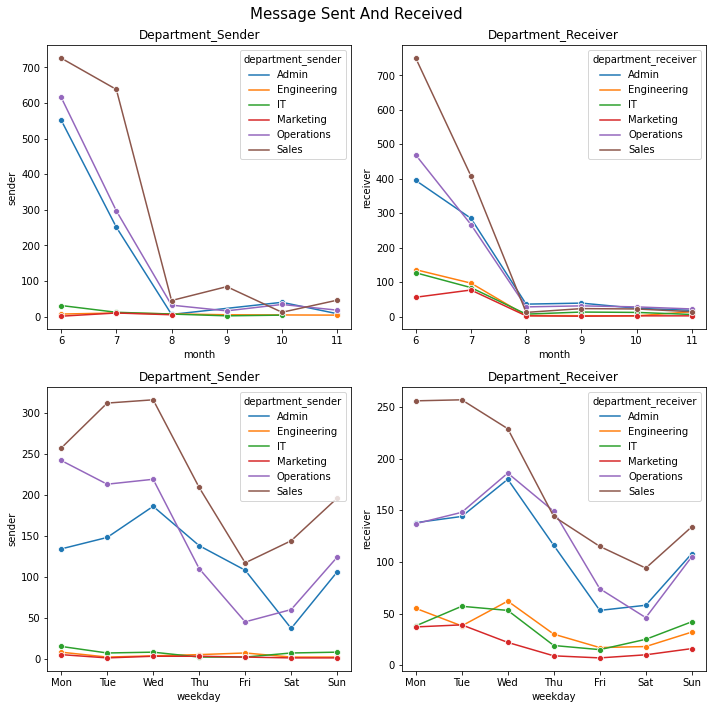

In [24]:
fig, ax=plt.subplots(2,2, figsize=(10,10))
plt.suptitle("Message Sent and Received".title(), fontsize=15)

# creating xticks labels for weekday-wise plots------------------------
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

# creating month-wise plots--------------------------------------------
ax[0,0]=sns.lineplot(data=month_send, x="month", y="sender", hue="department_sender",marker="o", palette="tab10", ax=ax[0,0],)
ax[0,0].set_title("Department_Sender")
ax[0,1]=sns.lineplot(data=month_receive, x="month", y="receiver", hue="department_receiver", marker="o",palette="tab10", ax=ax[0,1])
ax[0,1].set_title("Department_Receiver")

# creating weekday-wise plots-------------------------------------------
ax[1,0]=sns.lineplot(data=weekday_sender, x="weekday", y="sender", hue="department_sender",marker="o", palette="tab10", ax=ax[1,0],)
ax[1,0].set_title("Department_Sender")
ax[1,0].set_xticks(range(len(days)))
ax[1,0].set_xticklabels(days)
ax[1,1]=sns.lineplot(data=weekday_receiver, x="weekday", y="receiver", hue="department_receiver", marker="o",palette="tab10", ax=ax[1,1])
ax[1,1].set_title("Department_Receiver")
ax[1,1].set_xticks(range(len(days)))
ax[1,1].set_xticklabels(days)

plt.tight_layout();

- Sales, Operations and Admin departments appeared to be more active than the remaining departments. First two graphs shows number of messages sent and received on monthly basis where as the bottom two shows the same for weekdays. 
- Month-wise plots clearly indicates that Sales, Operation and Admin depmartments have busy days in the months June and July in terms of communicating with other colleagues
- People from Sales department sent and received messages almost 7 times more than Engineering, Marketing and IT departments.
- If we accumulate results on weekdays(bottom two plots), Engineering, IT and Marketing departments sent less than almost 25 messages and receive less than almost 75 messages for each particular weekday. 
- Even though Sales department looks on the top for most of the portions in the plot, there is overlapping at few points with Admin and Operations departments.
- It is not clearly visible which department is less active as IT, Engineering ans Marketing departments are sitting together at the bottom.

# Hypothesis Testing

We will use Hypothesis testing to statistically validate our hypothesis that sales department is the most active department among other departments.

- Since we have to check the proportions of messages sent by sales department, we will use t-proportion tests. 

### Hypotheses

##### Null Hypothesis:
    The proportion of messages sent by sales team is 40%
    
    i.e hypothesized_prop = 0.4
  
##### Alternate Hypothesis:
    The proportion of message sent by sales team is more than 40%
    

For hypothesis testing we will use significance level as 5%
     i.e alpha = 0.05
    

When we use hypothesis testing, we make primary assumptions that 
 1. sample is randomly selected 
 2. each observation is independent of other
 3. sample is big enough to follow normal distribution

 
Since the data set represents the messages sent by randomly chosen employees in the organisation for 6 months, data meets the criteria stated in first two assumptions. However, best way to check if these assumptions are valid is by checking whether the bootstrap distribution looks normal.


In [25]:
# Bootstrap Distibution ---------------------------------------
    
def bootstrap_dist(department):
    
    comm_boot_mean = []

    for i in range (5000):

        mean = (comm.sample(frac= 1, replace=True)\
        ["department_sender"]==department).mean()

        comm_boot_mean.append(mean)
        
    return comm_boot_mean


In [26]:
comm_boot_means= bootstrap_dist("Sales")

Standard error of the sample is: 0.008346008512996944


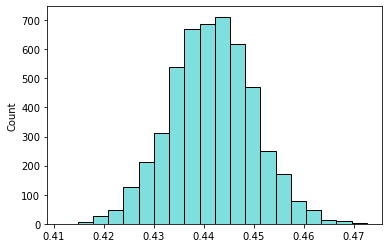

In [27]:
# standard error is the standard deviation of bootstrap distribution
std_error = np.std(comm_boot_means, ddof=1)
print("Standard error of the sample is:", std_error)
sns.histplot(comm_boot_means, bins=20, color ="c",alpha=0.5);

This is great news for us. 

- As we can see the bootstrap distibution looks normal, it is clear indication that our assumptions are valid.
- Secondly, the function also help us to find the standard error of the sample. Standarad error is defined as the standard deviation of a the sample statistic.

These two are great outputs to go further with our hypothesis testing


In [28]:
# from hypothesis statement------------------------------------------------
hypothesized_prop = 0.4
alpha = 0.05
print("Significance level is:", alpha)

# Sample proportion of Sales-----------------------------------------------
sample_prop = (comm["department_sender"]=="Sales").mean()

# z-score caluculation-----------------------------------------------------
z_score = (sample_prop - hypothesized_prop)/std_error
print("z-score is:", z_score)

# p-value-------------------------------------------------------------- 
p_value = 1- norm.cdf(z_score, loc=0, scale=1)
print("p-value is:", p_value)

# comparing significance level and p-values--------------------------------

if p_value<=alpha:
    print("As p value is less than or equal to significance level, we reject the NULL hypothesis")
    
else:
    print("As p value is more than or equal to significance level, we fail to reject the NULL hypothesis")

Significance level is: 0.05
z-score is: 4.987857552470276
p-value is: 3.052627830513188e-07
As p value is less than or equal to significance level, we reject the NULL hypothesis


Here p value is less than the significance level, thus, there is no strong evidence to support the null hypothesis. Hence, we reject the null hypothesis which states that the proportion of messages sent by sales department is 40%. In other words, the proportion of messages sent by sales team is more than 40%.

Let's also check whether the proportion of messages sent by sales is more than that of neighbouring Operation department

#### Null Hypothesis: 
Proportion of messages sent by sales is same as operations
    
#### Alternative Hypothesis: 
Proportion of messages sent by sales is more than operations


We will take significance level as 5%

In [29]:
count= comm['department_sender'].value_counts()
count

Sales          1551
Operations     1013
Admin           857
IT               49
Engineering      26
Marketing        16
Name: department_sender, dtype: int64

In [30]:
def two_proportion_test(var1, var2, alternative):
    '''the function returns the p-value for the sample'''
    success= np.array([count[var1],count[var2]])
    size = np.array([len(comm),len(comm)])
    z_score, p_value =proportions_ztest(count= success, nobs=size, alternative=alternative)   
    return p_value

In [31]:
p_value = two_proportion_test('Sales','Operations', 'larger')
print('p-value is:', p_value)
alpha= 0.05
print('Significance level is:', alpha)
if p_value<=alpha:
    print("As p value is less than or equal to significance level, we reject the NULL hypothesis")
    
else:
    print("As p value is more than or equal to significance level, we fail to reject the NULL hypothesis")

p-value is: 7.377959664588138e-41
Significance level is: 0.05
As p value is less than or equal to significance level, we reject the NULL hypothesis


In other words, there is enough evidence to say that proportion of messages sent by SALES department is more than OPERATIONS department

##### Above two results of hypothesis proportion testing is clear indication that the SALES Department is the MOST ACTIVE depatment in the organisation

## Least Active Department

From the line plots at the beginning of the section, it was not very clear about department which is least active. It was mainly because the proportion of messages sent by Marketing, IT and Engineering departments were very close to each other. Thus, we will again rely on two sample proportion test to find out if there is enough evidence to prove the least active department. 

To do this, we will go pairwise among Marketing, IT and Engineering groups 

Good thing is that we have already defined a function 'two_proportion_test()' to find out the p value of the sample

#### Marketing and Engineering

- Null Hypothesis: Proportion of messages sent by marketing is same as engineering
    
- Alternate Hypothesis: Proportion of messages sent by marketing is lower than engineering

In [32]:
# check whether Marketing is lesser active than Engineering
p_value = two_proportion_test('Marketing','Engineering', 'smaller')
print('p-value is:', p_value)
alpha= 0.05
print('Significance level is:', alpha)
if p_value<=alpha:
    print("As p value is less than or equal to significance level, we reject the NULL hypothesis")
    
else:
    print("As p value is more than or equal to significance level, we fail to reject the NULL hypothesis")

p-value is: 0.060851176253374294
Significance level is: 0.05
As p value is more than or equal to significance level, we fail to reject the NULL hypothesis


#### Marketing and IT
- Null Hypothersis: proportion of messages sent by marketing is same as IT
    
- Alternate Hypothesis: proportion of messages sent by marketing is lower as IT

In [33]:
# Check whether Marketing is lesser active than IT
p_value = two_proportion_test('Marketing','IT', 'smaller')
print('p-value is:', p_value)
alpha= 0.05
print('Significance level is:', alpha)
if p_value<=alpha:
    print("As p value is less than or equal to significance level, we reject the NULL hypothesis")
    
else:
    print("As p value is more than or equal to significance level, we fail to reject the NULL hypothesis")

p-value is: 1.9593827897321472e-05
Significance level is: 0.05
As p value is less than or equal to significance level, we reject the NULL hypothesis


#### Engineering and IT
- Null Hypothesis: Proportion of messages sent by engineering is same as IT
    
- Alternate Hypothesis: Proportion of messages sent by engineering is lower as IT

In [34]:
# check whether Engineering is lesser active than IT
p_value = two_proportion_test('Engineering','IT', 'smaller')
print('p-value is:', p_value)
alpha= 0.05
print('Significance level is:', alpha)
if p_value<=alpha:
    print("As p value is less than or equal to significance level, we reject the NULL hypothesis")
    
else:
    print("As p value is more than or equal to significance level, we fail to reject the NULL hypothesis")

p-value is: 0.003791379314606391
Significance level is: 0.05
As p value is less than or equal to significance level, we reject the NULL hypothesis


#### Result

From above three pairwise proportion hypothesis tests, we can conclude that:

- There is not enough evidence to differentiate the activeness of Marketing and Engineering departments. We failed to reject the hypothesis stating that the proportion of messages sent by Marketing is same as that of Engineering department.
- There is enough evidence that proportion of messages sent by Marketing department is lower that that of IT department
- Also, it is evident that proportion of messages sent by Engineering department is lower that that of IT department

##### All these test insinuate that MARKETING and ENGINEERING departments are the LEAST ACTIVE among all the departments

This is sign that HR team need to motivate employees from Marketing and Engineering teams to get more invloved with other employees and departments through interactions. The main skill for marketing role is said to be the communication. It could be that these employees interact more with clients and busy in site visits. However, internal communication is equally critical for organisationsal success. Similarly, Engineering and IT teams might be focusing more on developing and deploying models. Nonetheless, their inputs matter in decision making.

# Network Analysis

In [35]:
# Graph for connection among employees---------------------------
CG =nx.from_pandas_edgelist(comm, source="sender", target="receiver", 
                            edge_attr=True , create_using=nx.DiGraph())
# Graph for connection among departments-------------------------
DG= nx.from_pandas_edgelist(comm, source= "department_sender", 
                            target = "department_receiver", 
                            edge_attr=True, 
                            create_using=nx.DiGraph())

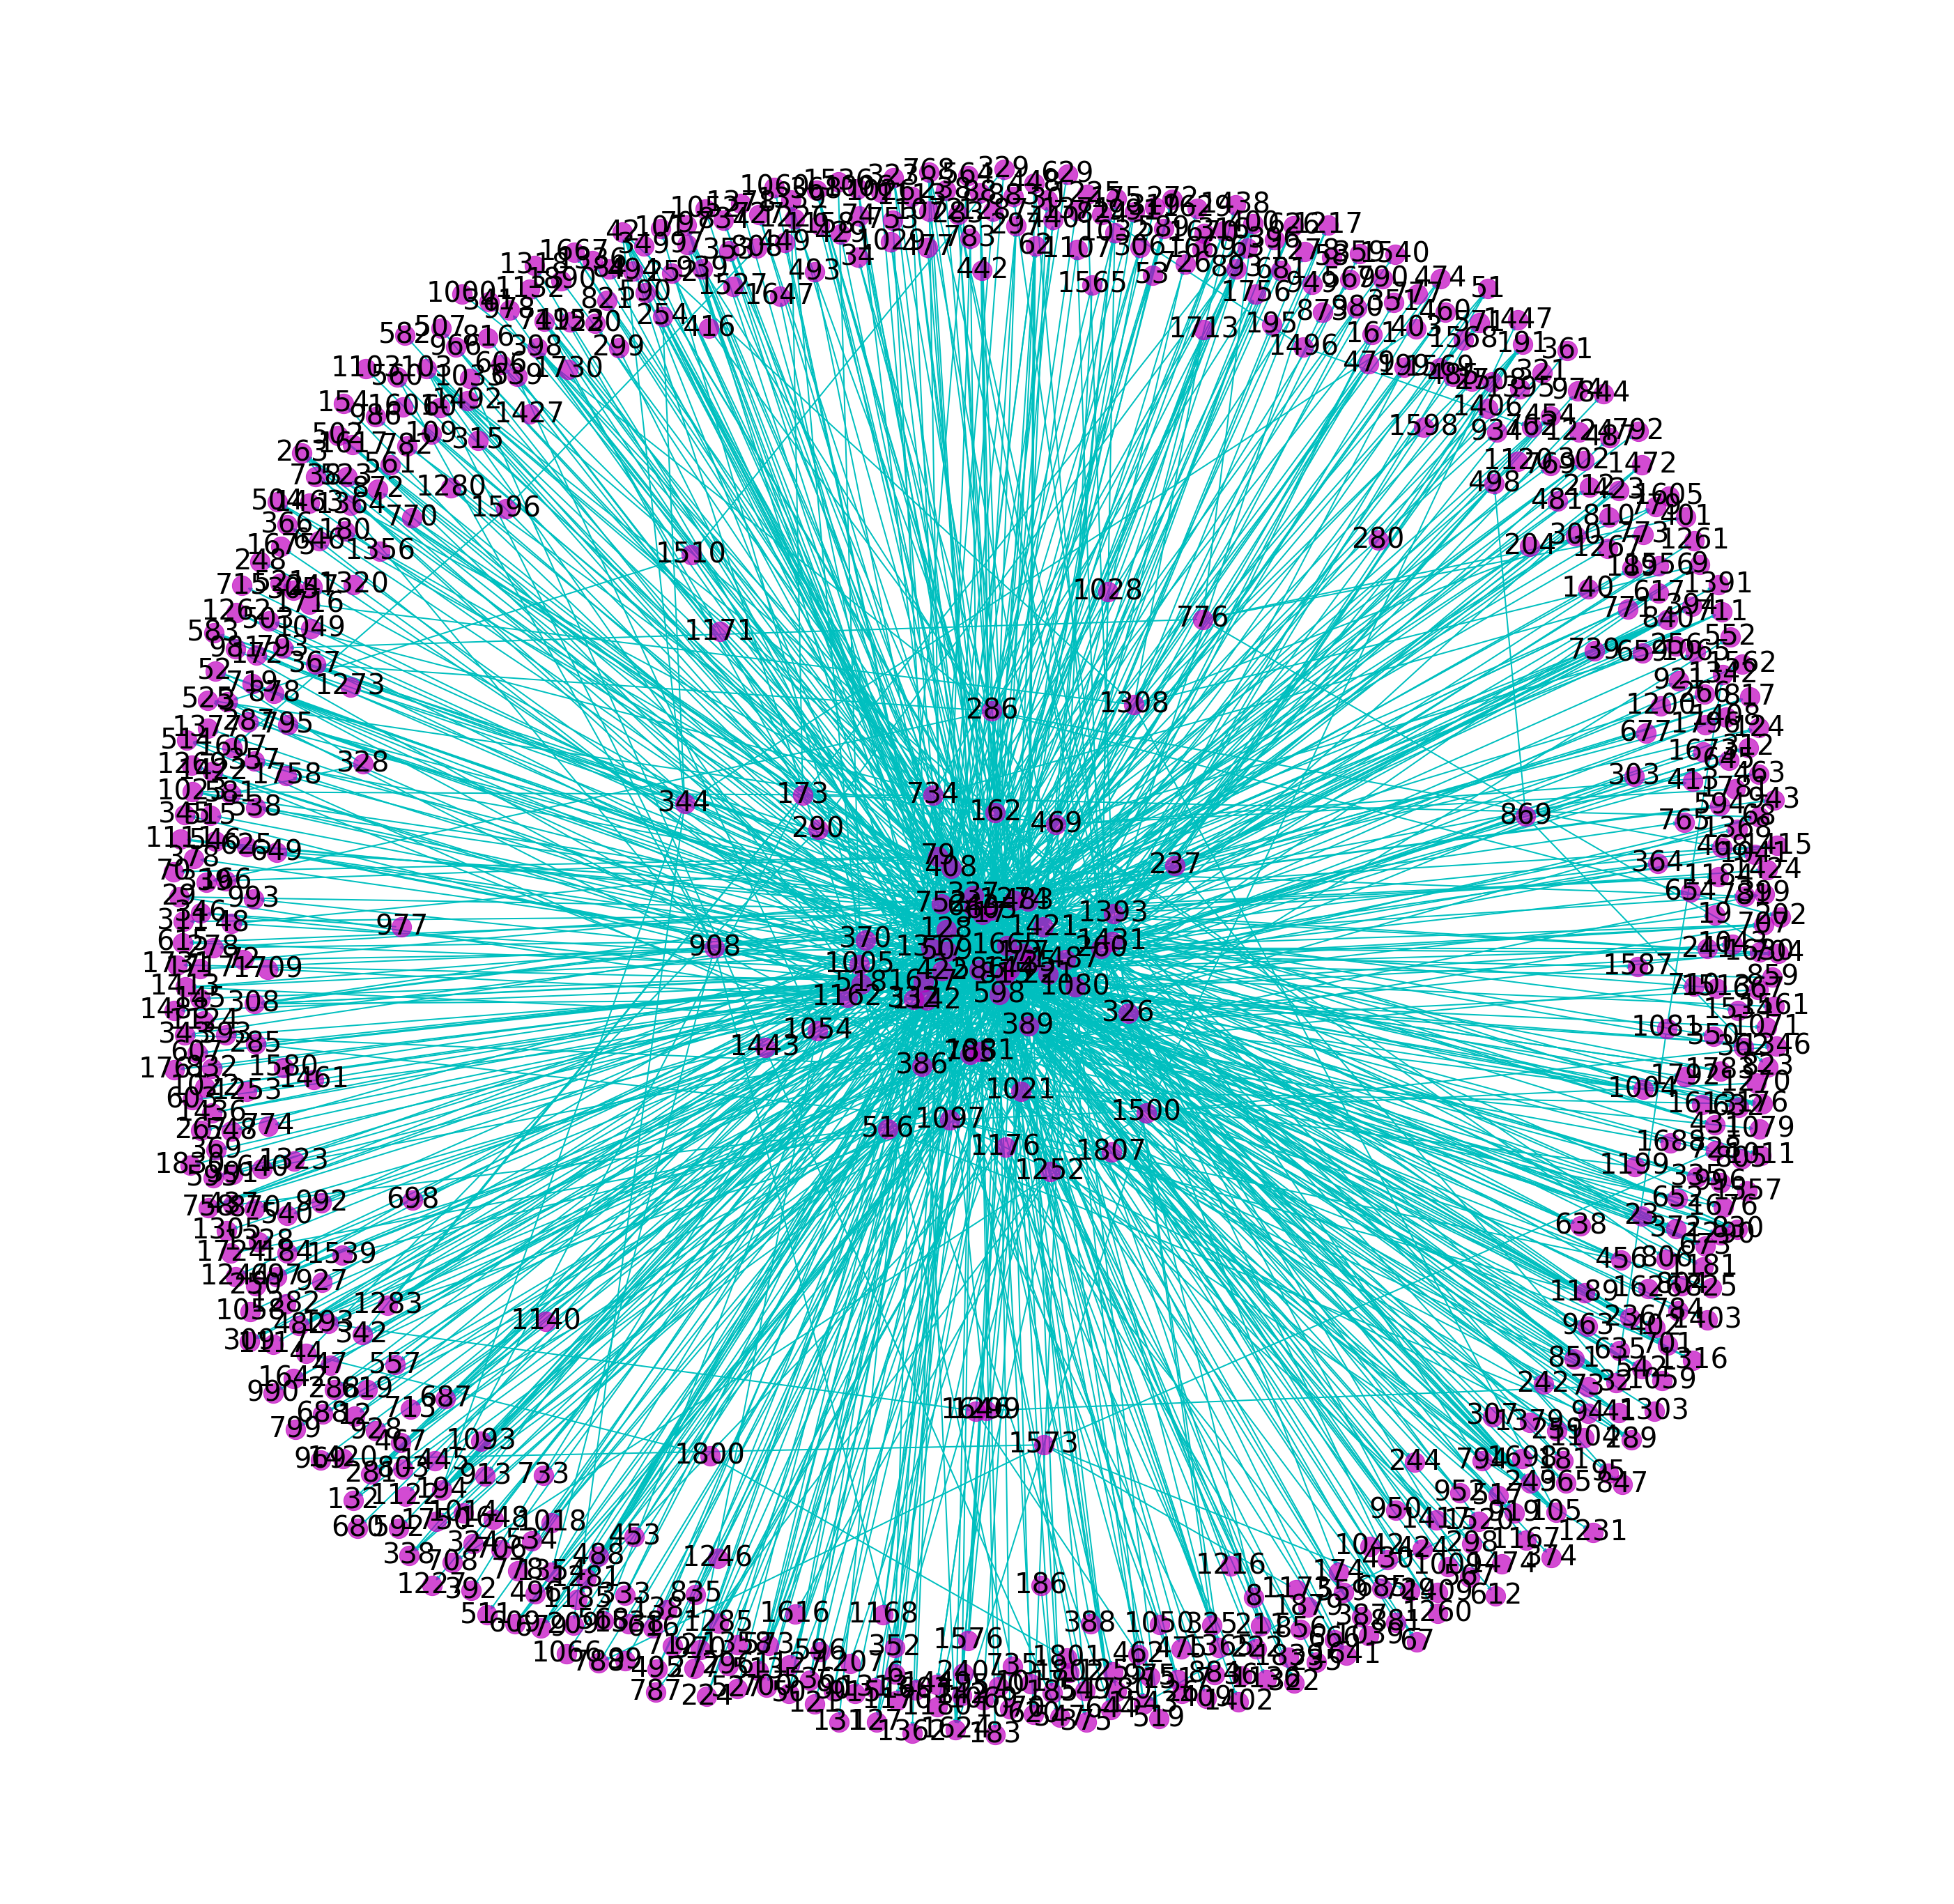

In [36]:
# Plotting graph for connections among employees
plt.figure(figsize=(50,50))
plt.axis("off")

# Setting layout
layout= nx.spring_layout(CG)

# Adding nodes

nx.draw_networkx_nodes(CG, pos=layout, node_size=800, node_color="m", alpha=0.7)
nx.draw_networkx_edges(CG, pos=layout, width=2, edge_color="c")
nx.draw_networkx_labels(CG, pos=layout, font_size=40)
plt.show()

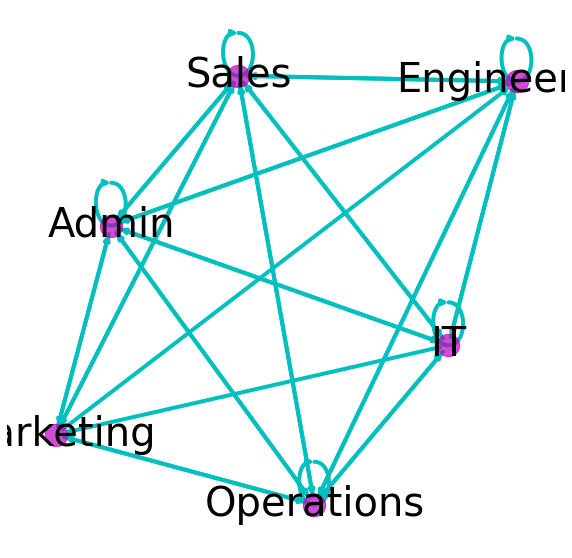

In [37]:
# Plotting graph for connections among employees
plt.figure(figsize=(10,10))
plt.axis("off")

# Setting layout
layout1= nx.spring_layout(DG)

# Adding nodes

nx.draw_networkx_nodes(DG, pos=layout1, node_size=500, node_color="m", alpha=0.7)
nx.draw_networkx_edges(DG, pos=layout1, width=4, edge_color="c")
nx.draw_networkx_labels(DG, pos=layout1, font_size=40)
plt.show()

### Who has maximum connections?

In [38]:
# Degree centrality - it represet how much degree or connection a node has
connections = nx.degree_centrality(CG)

# sorting the items based on max degree centrality---------------------
sorted(connections.items(), key= lambda x: x[1], reverse=True)[:5]

[(598, 0.12669683257918551),
 (144, 0.11764705882352941),
 (128, 0.11312217194570136),
 (605, 0.10708898944193063),
 (586, 0.09803921568627451)]

NetworkX's degree centrality is calculated by taking the degree of the node and dividing by n-1 where where n is the number of nodes in the graph

##### Employee with ID 598 has maximum degree centrality which mean he or she has stronger network than any other employee in the organization

Empoyees with IDs 144,128,605 and 586 also join the category of people having strong network

To find how many people these emplpoyee are connected with, we just have to find the degree of the perticular node

In [39]:
connections_num = dict(CG.degree)

In [40]:
sorted(connections_num.items(), key=lambda x:x[1], reverse=True)[:5]

[(598, 84), (144, 78), (128, 75), (605, 71), (586, 65)]

There you go!!! We have the list of top 5 employees and their number of interactions. Since this is directed graph we can find the out_degree (message sent) and in_degree(message received) for the nodes. It is given as below. 

In [41]:
# creating dictionary containing employee id and number of messages sent
send = dict(CG.out_degree())
# creating dictionary containing employee id and number of messages received
receive= dict(CG.in_degree())

In [42]:
# top 5 employees who sent max messages
sorted(send.items(), key=lambda x: x[1], reverse=True)[:5]

[(598, 77), (144, 75), (128, 71), (605, 68), (586, 64)]

In [43]:
# number of messages recieved by these top employees
top =[x[0] for x in sorted(send.items(), key=lambda x: x[1], reverse=True)[:5]]

top_receive = {}
for i in top:
    num = receive[i]
    top_receive[i]= num
    
print(top_receive.items())

dict_items([(598, 7), (144, 3), (128, 4), (605, 3), (586, 1)])


Just to summarise the above results, 

##### Employee with ID 598 had connected with 84 people during his/her interactions through messages. It is highest among all employees. He messaged 77 people and received messages from 7 of his peers



## Who has the least number of connections?

In [44]:
# sorting the items based on max degree centrality---------------------
sorted(connections.items(), key= lambda x: x[1], reverse=False)[:5]

[(58, 0.0015082956259426848),
 (70, 0.0015082956259426848),
 (109, 0.0015082956259426848),
 (99, 0.0015082956259426848),
 (121, 0.0015082956259426848)]

In [45]:
# setting counter
count = 0
for key in connections_num.keys():
    # condition for connection less than or equal to 5
    if connections_num[key] <=5:
        count += 1

print(count)

605


If we set the criteria that employees having less than or equal to 5 connection considered as least connected employees then,
###### In total, 605 employees are considered to be the least active with less than or equal to 5 connections. Out of these, 349 employees have only one connection.

## Most influencial Employee and Department

To find out who is the most influencial employee and department, we will use weighed average method.  let's also find closeness, betweeness and Eigenvector centrality. Lets first quickly see the meaning of these three terms:

#### Closeness Centrality:
   - it the reciporical of of the average value, which normalizes the value in a 0 to 1 range. It can be informally thought as 'average distance' to all other nodes.
   - Degree centrality measures might be criticized because they only take into account the immediate ties that an actor has, or the ties of the actor's neighbors, rather than indirect ties to all others. One actor might be tied to a large number of others, but those others might be rather disconnected from the network as a whole. In a case like this, the actor could be quite central, but only in a local neighborhood.[http://www.faculty.ucr.edu/~hanneman/nettext/C10_Centrality.html#Closeness]

#### Betweeness Centrality:
   - Betweenness centrality quantifies the number of times a node acts as a bridge (or "broker") along the shortest path between two other nodes.
   - Suppose that I want to buy a new flat in Pune. But, in order to contact the owner, I must go through an Broker. For example, let's suppose that I want to get the flat at the discounted price. Here firstly, I must forward my request to the broker. Broker could delay my request or influence it in some way. This gives the broker who lie "between" me and the flat owner the power with respect to me. Having more than one channel makes me less dependent, and, in a sense, more powerful.
   
##### Eigenvector Centrality:
   - A node is high in eigenvector centrality if it is connected to many other nodes who are themselves well connected. 
   - Suppose I have good amount of connections on linkedIn and my connections also have good amount connections, then my eigenvector centrality value is higher.

Instead of finding each values of centrality for both employee and department datadrame, we will first create the fuction which return the new dataframe containing the degree and different centrailty values. Please note that the each value is scalled using the maximun value in the respective column.

For employees, we will classify influencers in following categories and sort the top 2 employees in each categories as top influencers.

        - Proactive - High degree or degree centrality
        - Central members - High closeness centrality
        - Knowledge Broker - High betweenness centrality
        - Instrumental - High eigenvector centrality
        
For departments, we will use weighted average method to decide which department is influencing the most. The demaprtment is said to be networking-bellwhether in organisation when it work closely, promots maximum collaboration, and connects other critical departments. 

##### Based on this criterias, we will assign weighing factors to degree, closeness, betweenness and eigenvector centralities and calculate the mean value for each departments. We will assume that organisation provided the preferences as weight factors in a following manner:

        - degree--> 40%
        - closeness--> 30%
        - betweenness--> 20%
        - eigenvector--> 10%
        
Calculating values for each centralities for both employees and departments separately is cumbersome. We will make it easier by creating helper function centrality_dataframe(). It will take the graph as argument and returns the new dataframe containing the values for different centralilites. The function also scale the values of each centrality using maximum value of respective centrality.   
    
    

In [46]:
def centrality_dataframe(Graph):
    '''the function returns the new dataframe containing different centrality values for each observation'''

    # Degree------------------------------------------------------------------
    connections = dict(Graph.degree)
    # Degree centrality value-------------------------------------------------
    degree_emp = nx.degree_centrality(Graph)
    # closeness centrality value----------------------------------------------
    closeness_emp = nx.closeness_centrality(Graph)
    # betweeness centrality value---------------------------------------------
    betweeness_emp = nx.betweenness_centrality(Graph)
    # Eigenvector Centrality value--------------------------------------------
    eigen_emp = nx.eigenvector_centrality(Graph)

    # Normalising the values--------------------------------------------------
    max_val_deg = max(degree_emp.items(), key=lambda x: x[1])
    max_val_close = max(closeness_emp.items(), key=lambda x: x[1])
    max_val_between = max(betweeness_emp.items(), key=lambda x: x[1])
    max_val_eigen = max(eigen_emp.items(), key=lambda x: x[1])

    # Creating empty dictionaries
    deg_scaled ={}
    close_scaled ={}
    between_scaled={}
    eigen_scaled ={}

    for key in eigen_emp.keys():
        deg_scaled[key] = degree_emp[key]/max_val_deg[1]
        close_scaled[key] = closeness_emp[key]/max_val_close[1]
        between_scaled[key] = betweeness_emp[key]/max_val_between[1]
        eigen_scaled[key] = eigen_emp[key]/max_val_eigen[1]


    # Creating dataframe of number of connections-------------------------------
    df=pd.DataFrame.from_dict(connections.items())
    df.columns=["Employee_id", "Connections"]
    # Creating dataframe of degree centrality-----------------------------------
    df1=pd.DataFrame.from_dict(deg_scaled.items())
    df1.columns=["Employee_id", "Degree"]
    # Creating dataframe of closeness centrality--------------------------------
    df2=pd.DataFrame.from_dict(close_scaled.items())
    df2.columns=["Employee_id", "Closeness"]
    # Creating dataframe of Betweeness centrality-------------------------------
    df3=pd.DataFrame.from_dict(between_scaled.items())
    df3.columns=["Employee_id", "Betweenness"]
    # Creating dataframe of Eigenvector centrality------------------------------
    df4=pd.DataFrame.from_dict(eigen_scaled.items())
    df4.columns=["Employee_id", "Eigenvector"]


    # merging all the dataframes------------------------------------------------
    data = [df1,df2,df3,df4]

    for dataframe in data:
        df = df.merge(dataframe, on="Employee_id")
        
    return df

### Employees

In [47]:
centrality_dataframe(CG)

Employee_id  Connections    Degree  Closeness  Betweenness   Eigenvector
0             79           12  0.142857   0.513728     0.040852  2.601756e-01
1             48            2  0.023810   0.462963     0.000000  9.454764e-02
2             63            4  0.047619   0.694143     0.000000  3.509053e-01
3             58            1  0.011905   0.418871     0.000000  8.693082e-02
4             70            1  0.011905   0.418871     0.000000  8.693082e-02
..           ...          ...       ...        ...          ...           ...
659         1642            1  0.011905   0.058642     0.000000  8.474052e-15
660         1079            1  0.011905   0.058642     0.000000  8.474052e-15
661         1890            1  0.011905   0.058642     0.000000  8.474052e-15
662         1629            1  0.011905   0.399832     0.000000  6.618443e-02
663         1879            2  0.023810   0.000000     0.000000  3.259251e-16

[664 rows x 6 columns]

In [48]:
centrality_emp = centrality_dataframe(CG)
emp=employees.copy()
emp.columns=['Employee_id','department','location','age']
centrality_employees = emp.merge(centrality_emp, on='Employee_id')

In [49]:
proactive = centrality_employees.sort_values(by= 'Degree', ascending=False)[:5]
proactive.style.background_gradient(subset=['Connections', 'Degree','Closeness','Betweenness','Eigenvector'], 
                                    cmap='flare')

###### As we can see employee with ID 598  from Operations department has highest connections. He/she is selected as the 'Proactive' influencer

In [50]:
central = centrality_employees.sort_values(by= 'Closeness', ascending=False)[:5]
central.style.background_gradient(subset=['Connections', 'Degree','Closeness','Betweenness','Eigenvector'], 
                                  cmap='flare')

###### Employee with ID 32 from Sales department has closer working network than any other employee. He/she is selected as the 'Central' influencer

In [51]:
connectors = centrality_employees.sort_values(by= 'Betweenness', ascending=False)[:5]
connectors.style.background_gradient(subset=['Connections', 'Degree','Closeness','Betweenness','Eigenvector'], 
                                     cmap='flare')

###### Employee with ID 509 from Admin department has highest degree of betweenness. It means he/she acts as medium between more groups by joining connecting them to each other. He/she is selected as 'Connector' influencer 

In [52]:
rich_tiers = centrality_employees.sort_values(by= 'Eigenvector', ascending=False)[:5]
rich_tiers.style.background_gradient(subset=['Connections', 'Degree','Closeness','Betweenness','Eigenvector'], 
                                     cmap='flare')

##### Employee with ID 194 from Admin department has richer network than others. In other words, he/she is connected to people who also have larger network. Therefore, Employee with ID 194 is selected as 'Instrumental' influencer

### Departments

As said at the beginning of the section, we will add another column for weighted average of these centralities. Department with highest weighted average is selected as the influencer

In [53]:
centrality_dept= centrality_dataframe(DG)
centrality_dept['Weighted_average']= 0.4 * centrality_dept['Degree']+0.3* centrality_dept['Closeness']+ 0.2* centrality_dept['Betweenness']+ 0.1* centrality_dept['Eigenvector']
centrality_dept.style.background_gradient(subset=['Weighted_average'], cmap='crest')

##### I would say that this just is just the confirmation to our previous analysis. Sales, Operations and Admin departments have employees who are more connected, working closely, connecting different groups and having rich networks. All three departments have weighted average as 1. Hence, these departments are the Influencers in the organization. 

IT and Engineering deparments have significant connections with higher eigen values however moderate betweenness. Nonetheless, weighted average of Engineering is more than IT department as former is working more closely and have richer connections.

But look at the Marketing departement!! The department has the lowest weighted average. It is lowest in all the categories. While it shows moderate centralities in degree, closeness and eigenvector, it has absolute no power in bridging any two departments.

# What does it mean to HR Team and the organisation??

- The influencers are the nodes connecting and motivating the employees in the organizations. HR and communications departments can work with the influencers to improve the information flow by spreading messages through key nodes. 
- While we focused on the influencers,the network analysis helps to identify the peripheral or isolated nodes(employees). The departments can pay close attention to these employees and involve them in networking activities.
- The marketing and Engineering departments are identified to be the least active departments in the organization. The HR department needs to focus on these departments and find the reason for their less involvement in networking activities.
- While onboarding new employees, the HR department could pair new employees with the influencers or other key nodes so that new employees get acquainted with the different teams easily with more transparent information flow.

# Summary

- Sales department is the most active department 
- Marketing and Engineering departments are the least active departments. We do not have enough evidence to compare between these departments as we fail to reject the null hypothesis
- Employee with ID 598 has the most connection which includes 77 out-bound and 7 in-bound connections
- There are 605 employees in the organisation with less than or equal to 5 connections
- The employees with IDs 598, 32, 509 and 194 are collectively selected as the influencers as they possess different attributes such as proactiveness, closeness, acting as a bridge and instrumental networking ability, contributing to increase collaboration.
- Like activeness, Sales department is also proved to be the most influential department
- HR and communication departments need to put some efforts toimprove networking among Marketing and Engineering departments by organizing more social activities.